# Neural Network

## The first thing we will do is import all the libraries

In [260]:
import pandas as pd
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt

## Looking at the data

### One-vs-all encoding
For example: if our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

The code to covert the target vector.

In [261]:
def convert_y_to_vect(y, out_len):
    y_vect = np.zeros((len(y), out_len))
    for i in range(len(y)):
        y_vect[i, int(y[i])] = 1
    return y_vect

In [262]:
def transform_and_split_data(data):
    X = data[:, :-1]
    y = data[:, -1] - data[:, -1].min()
    print(f'Original y hist: {np.histogram(y, range(int(y.max()) + 1))}')
    y[y<=2] = 0.
    y[y==3] = 1.
    y[y>3] = 2.
    print(f'Current y hist: {np.histogram(y, [0, 1, 1.9])}')
    print(f'y min: {y.min()}, y max: {y.max()}')
    y_out_len = int(y.max()) + 1

    print("The shape of the wines dataset:")
    print(data.shape)
    print(y[:10])
    print(X[:10, :])

    # Scale the dataset
    X_scale = StandardScaler()
    X = X_scale.fit_transform(X)
    print(X) # Looking the new features after scaling

    #Split the data into training and test set.  60% training and %40 test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    # Converting the training and test targets to vectors
    y_v_train = convert_y_to_vect(y_train, y_out_len)
    y_v_test = convert_y_to_vect(y_test, y_out_len)
    # Check to see that our code performs as we expect
    print(y_train[0:10])
    print(y_v_train[0:10])

    return X_train, y_v_train, X_test, y_test, y_out_len

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [263]:
def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [264]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [265]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [266]:
def feed_forward(x, W, b, act_func):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = {} # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = act_func(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [267]:
def calculate_out_layer_delta(y, a_out, z_out, act_func_deriv):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * act_func_deriv(z_out)


def calculate_hidden_delta(delta_plus_1, w_l, z_l, act_func_deriv):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * act_func_deriv(z_l)

## The Back Propagation Algorithm


In [268]:
def train_nn(nn_structure, X, y, iter_num, act_func, act_func_deriv, l2_lambda=0, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%100 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b, act_func)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l], act_func_deriv)
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l], act_func_deriv)
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * ((1.0/N * tri_W[l]) + (l2_lambda * W[l]))
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers, act_func):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b, act_func)
        y[i] = np.argmax(a[n_layers])
    return y

### Plotting the learning curve


In [269]:
# plot the avg_cost_func
def plot_avg_cost(avg_cost_function, title):
    plt.plot(avg_cost_function)
    plt.title(title)
    plt.ylabel('Average J')
    plt.xlabel('Iteration number')
    plt.grid()
    plt.show()

### Function to analyze different methods

In [270]:
def nn_performance(title, nn_structure, X_train, y_v_train, X_test, y_test, num_of_iter, act_func, act_func_deriv, l2_lambda=0):
    # train the NN
    print(f'{title}:')
    W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, num_of_iter, act_func, act_func_deriv, l2_lambda)
    # Print accuracy of method
    y_pred = predict_y(W, b, X_test, 3, act_func)
    print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
    # Display plot of average cost per iterations
    plot_avg_cost(avg_cost_func, title)

### Other activation functions

In [271]:
def re_lu(z):
    z_cp = z.copy()
    z_cp[z_cp<0] = 0
    return z_cp

def re_lu_deriv(z):
    z_cp = z.copy()
    indices_under_zero = z_cp<0
    indices_over_zero = z_cp>=0
    z_cp[indices_under_zero] = 0
    z_cp[indices_over_zero] = 1
    return z_cp

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def tanh_deriv(z):
    return 1 - (tanh(z) ** 2)

def soft_plus(z):
    return np.log(1 + np.exp(z))

def soft_plus_deriv(z):
    return 1 / (1 + np.exp(-z))

# Train Neural Network

In [272]:
def train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len):
    print(f'Number of samples: {X_train.shape[0] + X_test.shape[0]}')
    nn_structure = [X_train.shape[1], 6, y_out_len] # [11, 6, 3]
    num_of_iterations = 3000
    l2_lambda = 0.0008

    nn_performance(f'Sigmoid, L2={l2_lambda}, Structure={nn_structure}', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, l2_lambda)


In [273]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
data_red = df_red.to_numpy()

df_white = pd.read_csv('winequality-white.csv', sep=';')
data_white = df_white.to_numpy()

data_all = np.vstack((data_red, data_white))

rs = r.RandomState(42)
r.shuffle(data_red)
r.shuffle(data_white)
r.shuffle(data_all)

# Train Red Wines Data

In [274]:
X_train, y_v_train, X_test, y_test, y_out_len = transform_and_split_data(data_red)

Original y hist: (array([ 10,  53, 681, 638, 217]), array([0, 1, 2, 3, 4, 5]))
Current y hist: (array([744, 638]), array([0. , 1. , 1.9]))
y min: 0.0, y max: 2.0
The shape of the wines dataset:
(1599, 12)
[0. 0. 1. 1. 0. 1. 0. 1. 0. 1.]
[[1.0000e+01 3.5000e-01 4.5000e-01 2.5000e+00 9.2000e-02 2.0000e+01
  8.8000e+01 9.9918e-01 3.1500e+00 4.3000e-01 9.4000e+00]
 [7.4000e+00 5.5000e-01 1.9000e-01 1.8000e+00 8.2000e-02 1.5000e+01
  3.4000e+01 9.9655e-01 3.4900e+00 6.8000e-01 1.0500e+01]
 [9.0000e+00 8.0000e-01 1.2000e-01 2.4000e+00 8.3000e-02 8.0000e+00
  2.8000e+01 9.9836e-01 3.3300e+00 6.5000e-01 1.0400e+01]
 [7.5000e+00 5.7000e-01 8.0000e-02 2.6000e+00 8.9000e-02 1.4000e+01
  2.7000e+01 9.9592e-01 3.3000e+00 5.9000e-01 1.0400e+01]
 [7.0000e+00 4.5000e-01 3.4000e-01 2.7000e+00 8.2000e-02 1.6000e+01
  7.2000e+01 9.9800e-01 3.5500e+00 6.0000e-01 9.5000e+00]
 [6.0000e+00 4.2000e-01 1.9000e-01 2.0000e+00 7.5000e-02 2.2000e+01
  4.7000e+01 9.9522e-01 3.3900e+00 7.8000e-01 1.0000e+01]
 [6.700

Number of samples: 1599
Sigmoid, L2=0.0008, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000
Prediction accuracy is 64.6875%


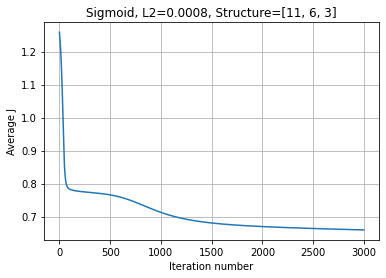

In [275]:
train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len)

# Train White Wines Data

In [276]:
X_train, y_v_train, X_test, y_test, y_out_len = transform_and_split_data(data_white)

Original y hist: (array([  20,  163, 1457, 2198,  880,  180]), array([0, 1, 2, 3, 4, 5, 6]))
Current y hist: (array([1640, 2198]), array([0. , 1. , 1.9]))
y min: 0.0, y max: 2.0
The shape of the wines dataset:
(4898, 12)
[0. 1. 1. 1. 0. 2. 1. 2. 0. 1.]
[[6.6000e+00 3.1000e-01 3.8000e-01 1.6050e+01 5.8000e-02 1.6000e+01
  1.6500e+02 9.9970e-01 3.3800e+00 6.0000e-01 9.2000e+00]
 [8.5000e+00 1.5000e-01 4.9000e-01 1.5000e+00 3.1000e-02 1.7000e+01
  1.2200e+02 9.9320e-01 3.0300e+00 4.0000e-01 1.0300e+01]
 [7.1000e+00 3.4000e-01 3.2000e-01 2.0000e+00 5.1000e-02 2.9000e+01
  1.3000e+02 9.9354e-01 3.3000e+00 5.0000e-01 1.0400e+01]
 [7.0000e+00 2.7000e-01 3.6000e-01 2.0700e+01 4.5000e-02 4.5000e+01
  1.7000e+02 1.0010e+00 3.0000e+00 4.5000e-01 8.8000e+00]
 [6.9000e+00 4.0000e-01 5.6000e-01 1.1200e+01 4.3000e-02 4.0000e+01
  1.4200e+02 9.9750e-01 3.1400e+00 4.6000e-01 8.7000e+00]
 [8.6000e+00 2.0000e-01 4.2000e-01 1.5000e+00 4.1000e-02 3.5000e+01
  1.2500e+02 9.9250e-01 3.1100e+00 4.9000e-01 1.1

Number of samples: 4898
Sigmoid, L2=0.0008, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000
Prediction accuracy is 55.91836734693878%


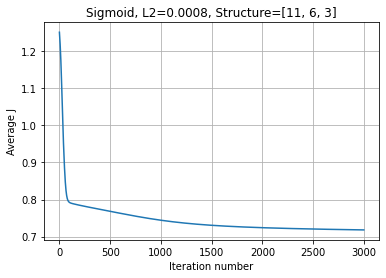

In [277]:
train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len)

# Train All Wines Data

In [278]:
X_train, y_v_train, X_test, y_test, y_out_len = transform_and_split_data(data_all)

Original y hist: (array([  30,  216, 2138, 2836, 1079,  198]), array([0, 1, 2, 3, 4, 5, 6]))
Current y hist: (array([2384, 2836]), array([0. , 1. , 1.9]))
y min: 0.0, y max: 2.0
The shape of the wines dataset:
(6497, 12)
[2. 1. 0. 0. 1. 2. 0. 2. 0. 0.]
[[7.9000e+00 4.6000e-01 3.2000e-01 4.1000e+00 3.3000e-02 4.0000e+01
  1.3800e+02 9.9120e-01 3.1800e+00 4.4000e-01 1.2800e+01]
 [7.2000e+00 2.7000e-01 2.7000e-01 2.4000e+00 4.8000e-02 3.0000e+01
  1.4900e+02 9.9360e-01 3.1000e+00 5.1000e-01 9.2000e+00]
 [6.9000e+00 2.8000e-01 3.7000e-01 9.1000e+00 3.7000e-02 1.6000e+01
  7.6000e+01 9.9480e-01 3.0500e+00 5.4000e-01 1.1100e+01]
 [7.2000e+00 2.3000e-01 3.8000e-01 6.1000e+00 6.7000e-02 2.0000e+01
  9.0000e+01 9.9496e-01 3.1700e+00 7.9000e-01 9.7000e+00]
 [6.8000e+00 2.6000e-01 4.8000e-01 6.2000e+00 4.9000e-02 5.5000e+01
  1.8200e+02 9.9582e-01 3.2100e+00 4.5000e-01 9.4000e+00]
 [6.5000e+00 3.7000e-01 3.0000e-01 2.2000e+00 3.3000e-02 3.9000e+01
  1.0700e+02 9.8894e-01 3.2200e+00 5.3000e-01 1.3

Number of samples: 6497
Sigmoid, L2=0.0008, Structure=[11, 6, 3]:
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 100 of 3000
Iteration 200 of 3000
Iteration 300 of 3000
Iteration 400 of 3000
Iteration 500 of 3000
Iteration 600 of 3000
Iteration 700 of 3000
Iteration 800 of 3000
Iteration 900 of 3000
Iteration 1000 of 3000
Iteration 1100 of 3000
Iteration 1200 of 3000
Iteration 1300 of 3000
Iteration 1400 of 3000
Iteration 1500 of 3000
Iteration 1600 of 3000
Iteration 1700 of 3000
Iteration 1800 of 3000
Iteration 1900 of 3000
Iteration 2000 of 3000
Iteration 2100 of 3000
Iteration 2200 of 3000
Iteration 2300 of 3000
Iteration 2400 of 3000
Iteration 2500 of 3000
Iteration 2600 of 3000
Iteration 2700 of 3000
Iteration 2800 of 3000
Iteration 2900 of 3000
Prediction accuracy is 56.44478645632935%


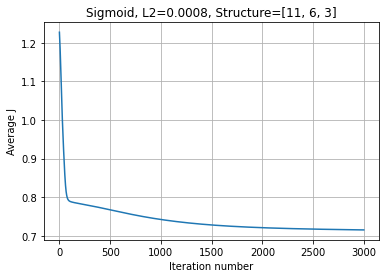

In [279]:
train_neural_network(X_train, y_v_train, X_test, y_test, y_out_len)

### Run performance analysis

In [280]:
# nn_performance('Sigmoid Activation Function', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv)
# Section a
# nn_performance('Sigmoid, L2 Regularization (lambda=0.01)', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, 0.01)
# Section b
# nn_performance('ReLU Activation Function',nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, re_lu, re_lu_deriv)
# Section c
# nn_performance('Tanh Activation Function', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, tanh, tanh_deriv)
# Section d
# nn_performance('Soft-plus Activation Function', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, soft_plus, soft_plus_deriv)
# Section e
# nn_performance('Sigmoid, 4000 Iterations (Not 3000)', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations + 1000, f, f_deriv)
# Section f
# diff_nn_structure = [X.shape[1], 16, y_out_len]
# nn_performance('Sigmoid, NN Structure = [11, 45 (Not 30), 10]', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv)

# for i in list(range(6, 7)) + list(range(11, 14)):
#     nn_structure[1] = i
#     print(f'Using NN Structure: {nn_structure}')
#     nn_performance('Sigmoid, L2 Regularization (lambda=0.001)', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, 0.001)

# Checking different l2 lambdas
# for l2_lambda in [0.0008]:
#     nn_performance(f'Sigmoid, L2={l2_lambda}, Structure={nn_structure}', nn_structure, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, l2_lambda)

# Checking different NN structures
# for nn in [nn_structure, [X.shape[1], 13, 11, y_out_len], [X.shape[1], 13, 6, y_out_len], [X.shape[1], 13, 3, y_out_len]]: # [11, 13, 3]]
#     nn_performance(f'Sigmoid, L2={l2_lambda}, Structure={nn}', nn, X_train, y_v_train, X_test, y_test, num_of_iterations, f, f_deriv, l2_lambda)